Getting started with Data
data manually downloaded from the internet (CMU's an4 dataset)
data already in .wav format

In [1]:
import os
data_dir = './data'  # Creates "data" folder in current directory
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

Look at an individual audio file

In [2]:
import librosa
import IPython.display as ipd

# Load and listen to the audio file
example_file = data_dir + '/an4/wav/an4_clstk/mgah/cen2-mgah-b.wav'
audio, sample_rate = librosa.load(example_file)

ipd.Audio(example_file, rate=sample_rate)

vizualize the audio file, the sound wave

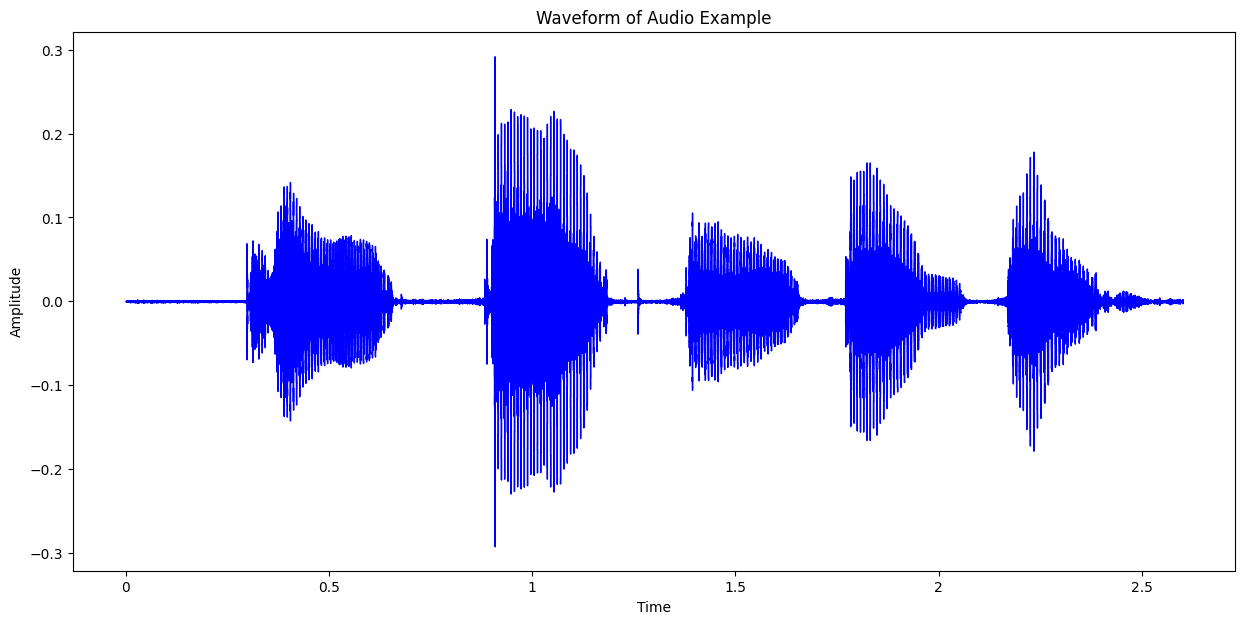

In [3]:
%matplotlib inline
import librosa.display
import matplotlib.pyplot as plt

# Plot our example audio file's waveform
plt.rcParams['figure.figsize'] = (15,7)
plt.title('Waveform of Audio Example')
plt.ylabel('Amplitude')

_ = librosa.display.waveshow(audio, color='blue')

spectrogram of the audio
x - axis  : time 
y - axis  : frequencies (on a log scale)

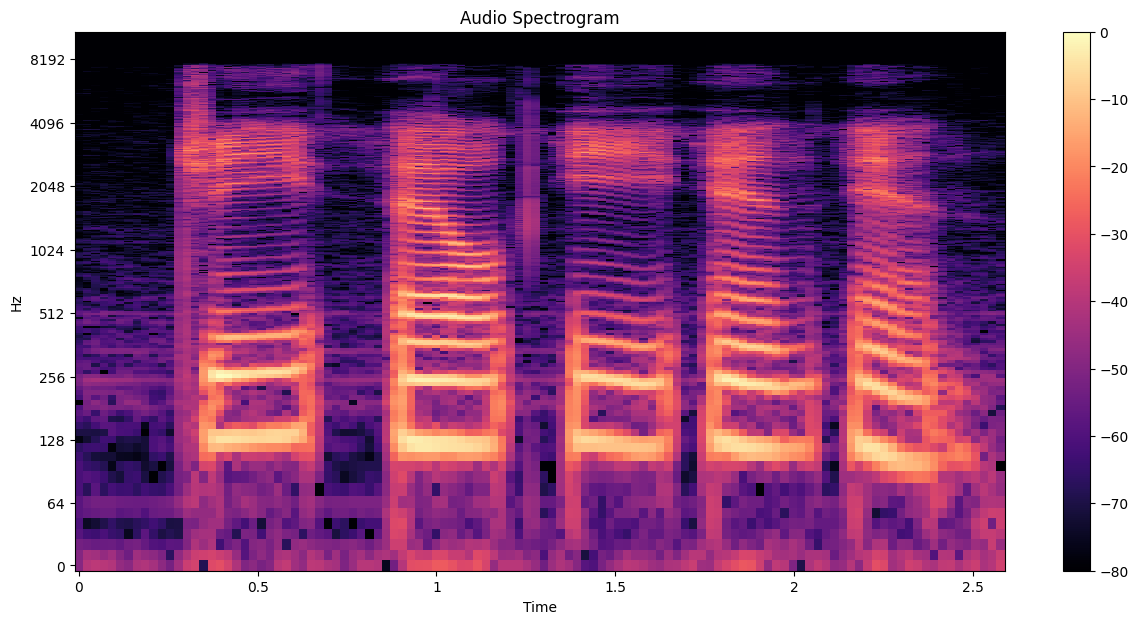

In [4]:
import numpy as np

# Get spectrogram using Librosa's Short-Time Fourier Transform (stft)
spec = np.abs(librosa.stft(audio))
spec_db = librosa.amplitude_to_db(spec, ref=np.max)  # Decibels

# Use log scale to view frequencies
librosa.display.specshow(spec_db, y_axis='log', x_axis='time')
plt.colorbar()
plt.title('Audio Spectrogram');

Mel Spectrogram
x - axis : time
y - axis : frequencies on mel scale (frequencies aligned to what humans perceive)

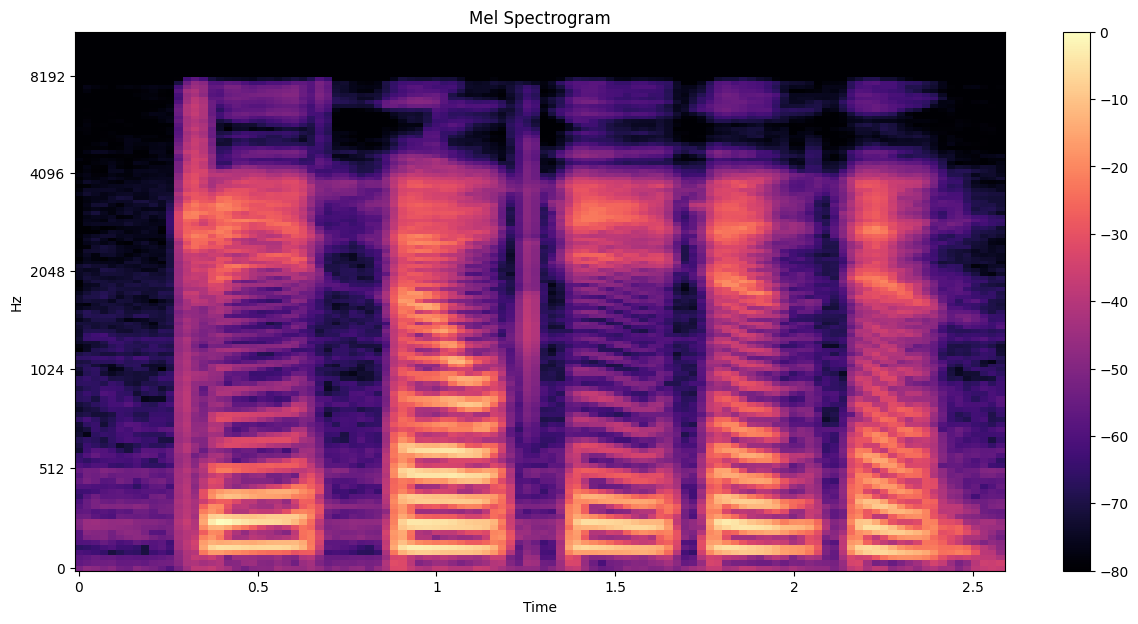

In [5]:
# Plot the mel spectrogram of our sample
mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

librosa.display.specshow(
    mel_spec_db, x_axis='time', y_axis='mel')
plt.colorbar()
plt.title('Mel Spectrogram');

Calling NeMo

In [6]:
import nemo
# NeMo's ASR collection - this collections contains complete ASR models and
# building blocks (modules) for ASR
import nemo.collections.asr as nemo_asr

/Users/anujain/Projects/Speaker-Diarization/myenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
W0918 14:09:10.427000 46827 torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.
[NeMo W 2025-09-18 14:09:12 nemo_logging:405] /Users/anujain/Projects/Speaker-Diarization/myenv/lib/python3.11/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
      warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
    


In [10]:
# This line will download pre-trained QuartzNet15x5 model from NVIDIA's NGC cloud and instantiate it for you
quartznet = nemo_asr.models.EncDecCTCModel.from_pretrained(model_name="asr_talknet_aligner")

[NeMo I 2025-09-18 14:49:51 nemo_logging:393] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/asr_talknet_aligner/versions/1.0.0rc1/files/qn5x5_libri_tts_phonemes.nemo to /Users/anujain/.cache/torch/NeMo/NeMo_2.4.0/qn5x5_libri_tts_phonemes/656c7439dd3a0d614978529371be498b/qn5x5_libri_tts_phonemes.nemo
[NeMo I 2025-09-18 14:49:51 nemo_logging:393] Download from cloud failed. Attempt 1 of 3
[NeMo I 2025-09-18 14:49:52 nemo_logging:393] Download from cloud failed. Attempt 2 of 3
[NeMo I 2025-09-18 14:49:52 nemo_logging:393] Download from cloud failed. Attempt 3 of 3


ValueError: Not able to download url right now, please try again.

In [8]:
nemo_asr.models.EncDecCTCModel.list_available_models()

[PretrainedModelInfo(
 	pretrained_model_name=QuartzNet15x5Base-En,
 	description=QuartzNet15x5 model trained on six datasets: LibriSpeech, Mozilla Common Voice                 (validated clips from en_1488h_2019-12-10), WSJ, Fisher, Switchboard, and NSC Singapore English.                     It was trained with Apex/Amp optimization level O1 for 600 epochs. The model achieves a WER of                     3.79% on LibriSpeech dev-clean, and a WER of 10.05% on dev-other. Please visit                         https://ngc.nvidia.com/catalog/models/nvidia:nemospeechmodels for further details.,
 	location=https://api.ngc.nvidia.com/v2/models/nvidia/nemospeechmodels/versions/1.0.0a5/files/QuartzNet15x5Base-En.nemo
 ),
 PretrainedModelInfo(
 	pretrained_model_name=stt_en_quartznet15x5,
 	description=For details about this model, please visit https://ngc.nvidia.com/catalog/models/nvidia:nemo:stt_en_quartznet15x5,
 	location=https://api.ngc.nvidia.com/v2/models/nvidia/nemo/stt_en_quartznet15x5/v

In [11]:
# --- Building Manifest Files --- #
import json

# Function to build a manifest
def build_manifest(transcripts_path, manifest_path, wav_path):
    with open(transcripts_path, 'r') as fin:
        with open(manifest_path, 'w') as fout:
            for line in fin:
                # Lines look like this:
                # <s> transcript </s> (fileID)
                transcript = line[: line.find('(')-1].lower()
                transcript = transcript.replace('<s>', '').replace('</s>', '')
                transcript = transcript.strip()

                file_id = line[line.find('(')+1 : -2]  # e.g. "cen4-fash-b"
                audio_path = os.path.join(
                    data_dir, wav_path,
                    file_id[file_id.find('-')+1 : file_id.rfind('-')],
                    file_id + '.wav')

                duration = librosa.core.get_duration(filename=audio_path)

                # Write the metadata to the manifest
                metadata = {
                    "audio_filepath": audio_path,
                    "duration": duration,
                    "text": transcript
                }
                json.dump(metadata, fout)
                fout.write('\n')
                
# Building Manifests
print("******")
train_transcripts = data_dir + '/an4/etc/an4_train.transcription'
train_manifest = data_dir + '/an4/train_manifest.json'
if not os.path.isfile(train_manifest):
    build_manifest(train_transcripts, train_manifest, 'an4/wav/an4_clstk')
    print("Training manifest created.")

test_transcripts = data_dir + '/an4/etc/an4_test.transcription'
test_manifest = data_dir + '/an4/test_manifest.json'
if not os.path.isfile(test_manifest):
    build_manifest(test_transcripts, test_manifest, 'an4/wav/an4test_clstk')
    print("Test manifest created.")
print("***Done***")

******
Training manifest created.
Test manifest created.
***Done***


In [13]:
try:
    from ruamel.yaml import YAML
except ModuleNotFoundError:
    from ruamel_yaml import YAML
config_path = './configs/config.yaml'

if not os.path.exists(config_path):
    # Grab the config we'll use in this example
    BRANCH = 'r2.0.0rc0'
    !mkdir configs
    !wget -P configs/ https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/examples/asr/conf/config.yaml

yaml = YAML(typ='safe')
with open(config_path) as f:
    params = yaml.load(f)
print(params)

{'name': 'QuartzNet15x5', 'sample_rate': 16000, 'repeat': 1, 'dropout': 0.0, 'separable': True, 'labels': [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'"], 'model': {'train_ds': {'manifest_filepath': '???', 'sample_rate': 16000, 'labels': [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'"], 'batch_size': 32, 'trim_silence': True, 'max_duration': 16.7, 'shuffle': True, 'num_workers': 8, 'pin_memory': True, 'is_tarred': False, 'tarred_audio_filepaths': None, 'shuffle_n': 2048, 'bucketing_strategy': 'synced_randomized', 'bucketing_batch_size': None}, 'validation_ds': {'manifest_filepath': '???', 'sample_rate': 16000, 'labels': [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'"], 'batch_size': 32, 'shuffle': False, 'num_work

In [19]:
import lightning as pl
trainer = pl.Trainer(devices=1, accelerator='gpu', max_epochs=50)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [20]:
print (trainer)

In [25]:
from omegaconf import DictConfig
params['model']['train_ds']['manifest_filepath'] = train_manifest
params['model']['validation_ds']['manifest_filepath'] = test_manifest

params['model']['train_ds']['num_workers'] = 0
params['model']['validation_ds']['num_workers'] = 0

first_asr_model = nemo_asr.models.EncDecCTCModel(cfg=DictConfig(params['model']), trainer=trainer)

[NeMo I 2025-09-18 19:04:41 nemo_logging:393] Model level config does not contain `sample_rate`, please explicitly provide `sample_rate` to the dataloaders.
[NeMo I 2025-09-18 19:04:41 nemo_logging:393] Model level config does not contain `labels`, please explicitly provide `labels` to the dataloaders.
[NeMo I 2025-09-18 19:04:41 nemo_logging:393] Dataset loaded with 948 files totalling 0.71 hours
[NeMo I 2025-09-18 19:04:41 nemo_logging:393] 0 files were filtered totalling 0.00 hours
[NeMo I 2025-09-18 19:04:41 nemo_logging:393] Model level config does not contain `sample_rate`, please explicitly provide `sample_rate` to the dataloaders.
[NeMo I 2025-09-18 19:04:41 nemo_logging:393] Model level config does not contain `labels`, please explicitly provide `labels` to the dataloaders.
[NeMo I 2025-09-18 19:04:41 nemo_logging:393] Dataset loaded with 130 files totalling 0.10 hours
[NeMo I 2025-09-18 19:04:41 nemo_logging:393] 0 files were filtered totalling 0.00 hours
[NeMo I 2025-09-18 1

In [26]:
trainer.fit(first_asr_model)

[NeMo I 2025-09-18 19:04:52 nemo_logging:393] Optimizer config = Novograd (
    Parameter Group 0
        amsgrad: False
        betas: [0.8, 0.5]
        eps: 1e-08
        grad_averaging: False
        lr: 0.01
        weight_decay: 0.001
    )
[NeMo I 2025-09-18 19:04:52 nemo_logging:393] Scheduler "<nemo.core.optim.lr_scheduler.CosineAnnealing object at 0x35b364b90>" 
    will be used during training (effective maximum steps = 1500) - 
    Parameters : 
    (warmup_steps: null
    warmup_ratio: null
    min_lr: 0.0
    last_epoch: -1
    max_steps: 1500
    )



  | Name              | Type                              | Params | Mode 
--------------------------------------------------------------------------------
0 | preprocessor      | AudioToMelSpectrogramPreprocessor | 0      | train
1 | encoder           | ConvASREncoder                    | 1.2 M  | train
2 | decoder           | ConvASRDecoder                    | 29.7 K | train
3 | loss              | CTCLoss                           | 0      | train
4 | spec_augmentation | SpectrogramAugmentation           | 0      | train
5 | wer               | WER                               | 0      | train
--------------------------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.836     Total estimated model params size (MB)
135       Modules in train mode
0         Modules in eval mode


[NeMo W 2025-09-18 19:04:52 nemo_logging:405] /Users/anujain/Projects/Speaker-Diarization/myenv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
    


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

NotImplementedError: The operator 'aten::_ctc_loss' is not currently implemented for the MPS device. If you want this op to be considered for addition please comment on https://github.com/pytorch/pytorch/issues/141287 and mention use-case, that resulted in missing op as well as commit hash a1cb3cc05d46d198467bebbb6e8fba50a325d4e7. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.